### Use CNN with PyTorch to learn CIFAR-10 (cuda)

In [1]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Hyper parameters
num_epochs = 25
hidden_size = 50
input_channels = 3
num_classes = 10
batch_size = 100
learning_rate = 0.001

In [3]:
torch.cuda.is_available()

True

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Load CIFAR-10 dataset
Can be downloaded by `torchvision.datasets`

https://pytorch.org/docs/stable/torchvision/datasets.html

In [5]:
# CIFAR-10 dataset (32x32 colour images in 10 classes)
# https://www.cs.toronto.edu/~kriz/cifar.html
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='dataset/',
                                           train=True, 
                                           transform=transform,
                                           download=True)

test_dataset = torchvision.datasets.CIFAR10(root='dataset/',
                                          train=False, 
                                          transform=transform,
                                          download=True)

Files already downloaded and verified
Files already downloaded and verified


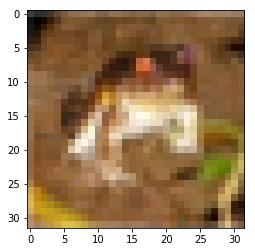

In [6]:
plt.imshow(train_dataset.train_data[0])

In [7]:
print('Original train size:', train_dataset.train_data.shape)
print(len(train_dataset.train_labels))
print('Original test size:', test_dataset.test_data.shape)
print(len(test_dataset.test_labels))

Original train size: (50000, 32, 32, 3)
50000
Original test size: (10000, 32, 32, 3)
10000


In [8]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

### See data dimensions and show images

In [9]:
sample_train_data = iter(train_loader)
images, labels = sample_train_data.next()

In [10]:
print('After DataLoader')
print('Train dimensions:', images.shape)
print(len(labels))

After DataLoader
Train dimensions: torch.Size([100, 3, 32, 32])
100


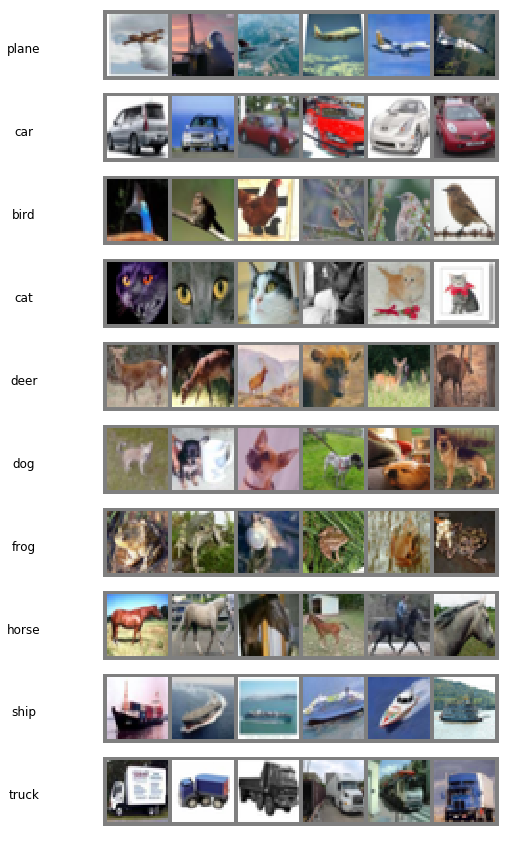

In [11]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

fig = plt.figure(figsize = (15, 15))
def show_photo(img, i, lname):
    img = img / 2 + 0.5
    npimg = img.numpy()
    ax = fig.add_subplot(10, 1, i)
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.axis('off')
    ax.set_title(label=lname, x=-0.2, y=0.3)

for label, lname in enumerate(classes):
    target_label = (labels == label)
    imgs = images[target_label][:6]   
    show_photo(torchvision.utils.make_grid(imgs), label + 1, lname)


### Padding & Stride

- Valid padding (zero padding)
    - input size (4x4) > output size (2x2) (stride=1, kernel=3x3)

- Same padding (non-zero padding)
    - input size (5x5) = output size (5x5) (stride=1, kernel=3x3)

- Output size

    $ O = \frac {W-K+2P}{S} + 1 $
    - O: output h/w
    - W: input h/w
    - K: filter size(kernel size)
    - P: padding
        - $  P = \frac {K-1}{2} $
    - S: stride

### Model 1:


```
Network
Input ->
Conv -> ReLU -> Conv -> ReLU ->MaxPool -> 
Conv -> ReLU -> Conv -> ReLU ->MaxPool -> 
Fully Connected Layer(Logits -> Softmax) -> Labels
```

```
Convolutional layer formula:
- Filter(Kernel) size K = 3 => (3 x 3)
- P(same padding) P = (3-1)/2=1
- S(stride) S = 1
- in_channels = 1 (gray image)
- out_channels (int) – Number of channels produced by the convolution = 16
Pooling layer formula:
- K = 2 => (2 x 2)
```



```
Dimensions:
-> Input(32, 32) 
-> Conv (16, 32, 32) 
-> Conv (16, 32, 32) 
-> MaxPool (16, 16, 16)
-> Conv (32, 16, 16)
-> Conv (32, 16, 16) 
-> MaxPool (32, 8, 8)
-> Fully Connected Layer(Logits (10, 1) -> Softmax) -> Labels
```

### Build CNN model

In [12]:
class PytorchDeepConvNet(nn.Module):
    def __init__(self, input_channels, num_classes=10):
        super(PytorchDeepConvNet, self).__init__()

        # Layer 1: conv - relu - conv- relu - pool
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=input_channels, out_channels=16, kernel_size=3, stride=1, padding=1),
            # Add BatchNorm2d() layer
#             nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))        
        
        # Layer 2: conv - relu - conv- relu - pool
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            # Add BatchNorm2d() layer
#             nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        # Fully Connected 1 (readout)
        self.fc1 = nn.Linear(32 * 8 * 8, num_classes)
        
        # Initialize all parameters using kaiming normalization
        self.init_weights_kaiming()
    
    def init_weights_kaiming(self):
        for layer in [self.layer1, self.layer2]:
            for m in layer:
                if type(m) == nn.Conv2d:
                    m.weight = nn.init.kaiming_normal_(m.weight)
        
        self.fc1.weight = nn.init.kaiming_normal_(self.fc1.weight)

    def forward(self, x):

        out = self.layer1(x)
        out = self.layer2(out)
        
        out = out.view(out.size(0), -1)
    
        # Linear function (readout)
        out = self.fc1(out)
        
        return out

In [13]:
model = PytorchDeepConvNet(input_channels, num_classes).to(device)
print(model)

PytorchDeepConvNet(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2048, out_features=10, bias=True)
)


In [14]:
print('parameter dimensions:')
for param in model.layer1.parameters():
    print(param.shape)

for param in model.layer2.parameters():
    print(param.shape)

for param in model.fc1.parameters():
    print(param.shape)

parameter dimensions:
torch.Size([16, 3, 3, 3])
torch.Size([16])
torch.Size([16, 16, 3, 3])
torch.Size([16])
torch.Size([32, 16, 3, 3])
torch.Size([32])
torch.Size([32, 32, 3, 3])
torch.Size([32])
torch.Size([10, 2048])
torch.Size([10])


In [15]:
criterion = nn.CrossEntropyLoss()

In [16]:
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Use Adam as the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [17]:
iter = 0
accuracies = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Load images as Variable
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)
        
        # Clear gradients w.r.t parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        outputs = model(images)
        
        # Calculate Loss: Softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        # Getting gradients w.r.t paramters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        
        iter += 1
        
        if iter % 500 == 0:
            correct = 0
            total = 0
            for images, labels in test_loader:
                images = Variable(images).to(device)
                outputs = model(images)
                
                _, predicted = torch.max(outputs.data, 1)
                
                # Total numer of labels
                total += labels.size(0)
                
                correct += (predicted.to(device) == labels.to(device)).sum()
            
            accuracy = 100 * correct / total
            accuracies.append(accuracy)
        
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.data.item(), accuracy))

Iteration: 500. Loss: 1.4869002103805542. Accuracy: 57
Iteration: 1000. Loss: 0.9936210513114929. Accuracy: 64
Iteration: 1500. Loss: 0.8289165496826172. Accuracy: 67
Iteration: 2000. Loss: 0.8718928694725037. Accuracy: 68
Iteration: 2500. Loss: 0.9093241095542908. Accuracy: 69
Iteration: 3000. Loss: 0.646176278591156. Accuracy: 68
Iteration: 3500. Loss: 0.7116777300834656. Accuracy: 71
Iteration: 4000. Loss: 0.6203567385673523. Accuracy: 71
Iteration: 4500. Loss: 0.5638858675956726. Accuracy: 70
Iteration: 5000. Loss: 0.8265963792800903. Accuracy: 70
Iteration: 5500. Loss: 0.681610107421875. Accuracy: 71
Iteration: 6000. Loss: 0.4991567134857178. Accuracy: 69
Iteration: 6500. Loss: 0.5252169966697693. Accuracy: 71
Iteration: 7000. Loss: 0.4952487051486969. Accuracy: 70
Iteration: 7500. Loss: 0.6998335123062134. Accuracy: 70
Iteration: 8000. Loss: 0.5358666181564331. Accuracy: 70
Iteration: 8500. Loss: 0.4426601529121399. Accuracy: 69
Iteration: 9000. Loss: 0.4438292384147644. Accuracy

In [18]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))


Test Accuracy of the model on the 10000 test images: 69.43 %


In [21]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    print('Test Accuracy of the model on the 50000 train images: {} %'.format(100 * correct / total))


Test Accuracy of the model on the 50000 train images: 88.28 %


### Model 2:

- try `dropout` after fully-connected layers


### Test memo:

#### Model 1

|dataset size(train/test)|#epoch|      model  |  optimizer | parameters |lr| accuracy(test/train)  |
|-----------------------|-------|--------------|------------|------------|--|------------|
|50000/10000|20|(conv - relu - conv- relu - pool)x2, Linearx1 |torch.optim.Adam|Kaiming He|0.001| 69.43%/ 88.28%|

In [22]:
# Save the model checkpoint
torch.save(model.state_dict(), 'model_m1.ckpt')